# Identificacion de grupos con los resultados de la prediccion anterior
## Imports

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/home/scidb/HeartRatePatterns/Python"))
from LogisticRegresion import ajustLogisticRegression
from PlotWords import plot_word
from Matrix import convert_matrix
from NMF import generateNMF,auc_model

## Número de componentes por los que se factorizara la tabla segun el resultado anterior

In [2]:
n_components=36

In [3]:
def findpatient(message,table,beats):
    groupsize = table.shape[0]
    deads = sum(table.index.labels[1].tolist())
    percent = -1 if groupsize==0 else deads/groupsize
    if groupsize!=0:
        print(message,"groupsize:%d"%groupsize,"deads:%d"%deads,"percent:{0:.2%}".format(percent),beats)

In [4]:
import psycopg2
def selectPearson(word,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_statement='SELECT patient,deadpatient,p1 FROM wordspearson WHERE word = %s'
#    print(cur.mogrify(select_statement,locals()))
    cur.execute(select_statement,(word,))
    select = {}
    for row in cur :
        patient=row[0]
        select = {'word':word,"pacientes":patient,"porcentaje de muertos":"{0:.2%}".format(row[1]/patient),"p1":row[2]}
    cur.close()
    conn.close()
    return select

In [5]:
def print_top_words(model, feature_names,topic_index=None):
    result = []
    for topic_idx, topic in enumerate(components):
        features = [{"word":feature_names[i],"p1":topic[i]} 
                    for i in topic.argsort()[:-1] if topic[i] > 0]
        if features!=[] and (topic_index==None or topic_index==topic_idx): result.append({"topic":topic_idx,"features":features})
    return result

In [6]:
def addValue(key,my_dict):
    if key in my_dict:
        my_dict[key] += 1
    else:
        my_dict[key] = 1
    return my_dict

In [7]:
from operator import itemgetter
def predict_proba(modelnmf,compoT,table):
    predicts = modelnmf.predict_proba(compoT)[:,1]
    beats = list(table)
    sortedBeats = []
    numPred = len(predicts)
    nvals={}
    for i in range(0,numPred):
        word = beats[i]
        sel = selectPearson(word)
        if sel=={}:
            print("palabra no encontrada en pearson:",word)
        cuantosMueren=sel['porcentaje de muertos']+" de "+str(sel['pacientes'])
        sortedBeats.append({'word':beats[i],'predict':predicts[i],'cuantosMueren':cuantosMueren,"p1":sel['p1']})
        if predicts[i]>.99 : addValue("99",nvals)
        elif predicts[i]>.90 : addValue("90",nvals)
        elif predicts[i]>.80 : addValue("80",nvals)
        elif predicts[i]>.70 : addValue("70",nvals)
        else: addValue("under",nvals)
    print(nvals)
    return sorted(sortedBeats, key=itemgetter('p1'), reverse=True)

In [8]:
table = convert_matrix()
survived = table.index.labels[1].tolist()
patients = table.values

(590, 18683)


In [9]:
from sklearn.model_selection import train_test_split
patients_train, patients_test,survived_train, survived_test = train_test_split(patients,survived,test_size=0.2, random_state=42)

In [10]:
modelnmf, nmf, patients_nmf, nmf_roc_auc, acurracy = generateNMF(patients,survived,n_components=n_components)

acurracy is 72.88%
NMF 36 AUC = 0.5122f


In [11]:
import numpy as np
compoT = np.transpose(nmf.components_)
print("components",nmf.components_.shape)
print("components Transpose",compoT.shape)

components (36, 18683)
components Transpose (18683, 36)


In [12]:
sortedBeats = predict_proba(modelnmf,compoT,table)
beatKeys = []
for value in sortedBeats:
    beatKeys.append(value['word'])

{'70': 17587, '80': 431, '99': 55, '90': 199, 'under': 411}


Top 5 HeartBeats con mayor probabilidad de muerte según la regresión logística
[{'predict': 0.81771943101545941, 'word': 'adc', 'cuantosMueren': '89.68% de 155', 'p1': 0.208886190046134}, {'predict': 0.77448090706216766, 'word': 'fdf', 'cuantosMueren': '96.39% de 83', 'p1': 0.203783764475214}, {'predict': 0.74945427850700153, 'word': 'dbda', 'cuantosMueren': '85.07% de 221', 'p1': 0.189067111670612}, {'predict': 0.77421364772369639, 'word': 'fbd', 'cuantosMueren': '87.27% de 165', 'p1': 0.183704825193073}, {'predict': 0.76795906638110922, 'word': 'dff', 'cuantosMueren': '93.18% de 88', 'p1': 0.180136446835082}]


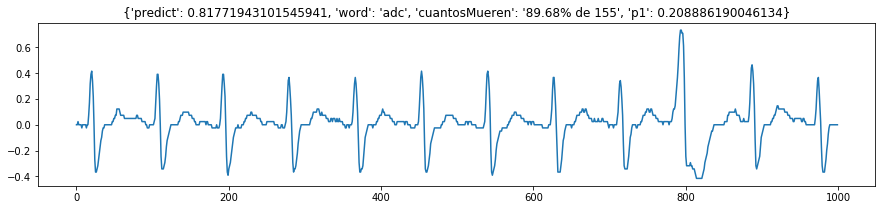

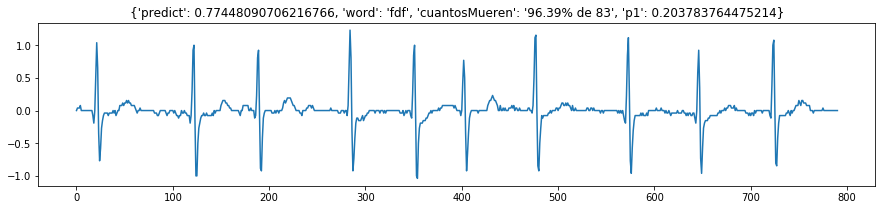

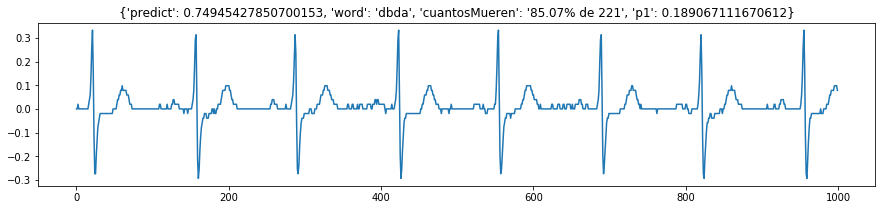

fbd 10673494 10674221 mimic2wdb/matched/s17997/s17997-2535-08-13-18-51


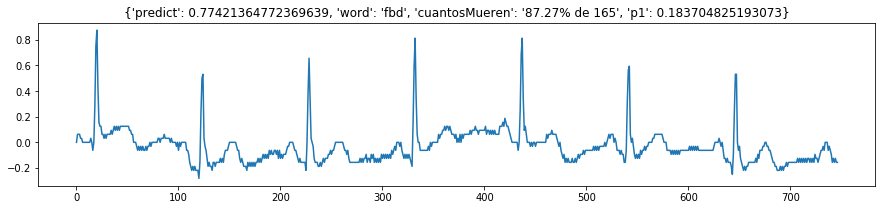

dff 171960 172723 mimic2wdb/matched/s04805/s04805-2808-01-08-12-32


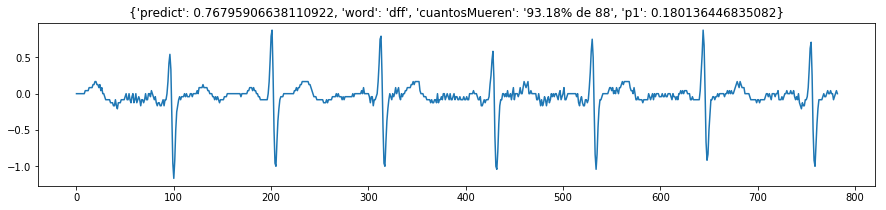

In [13]:
print("Top 5 HeartBeats con mayor probabilidad de muerte según la regresión logística")
print(sortedBeats[:5])
plot_word(sortedBeats[:5])

In [14]:
from operator import itemgetter
from scipy.stats.stats import pearsonr
patients_trainnmf = nmf.transform(patients_train)
pearsonList = []
for i in range(n_components):
    patientpear=patients_trainnmf[:,i]
    pearson = pearsonr(patientpear,survived_train)
  #  if(pearson[0]>0):
    pearsonList.append({'group':i,'p1':pearson[0],'p2':pearson[1]})
sortedList = sorted(pearsonList, key=itemgetter('p1'), reverse=True)
sortedList[:10]

[{'group': 33, 'p1': 0.15897127988378437, 'p2': 0.00052698313247989399},
 {'group': 17, 'p1': 0.10746705114941725, 'p2': 0.019524720058227116},
 {'group': 7, 'p1': 0.090479037340434137, 'p2': 0.049469045476744099},
 {'group': 3, 'p1': 0.087619700983466539, 'p2': 0.057145081081920075},
 {'group': 18, 'p1': 0.069209569481621602, 'p2': 0.13324422099547187},
 {'group': 9, 'p1': 0.061289835183786515, 'p2': 0.18375715709847418},
 {'group': 13, 'p1': 0.053191110154711813, 'p2': 0.24876298508225086},
 {'group': 28, 'p1': 0.050219433075507081, 'p2': 0.27622464925620144},
 {'group': 31, 'p1': 0.046404731960274476, 'p2': 0.31439744844735334},
 {'group': 34, 'p1': 0.043332239859169175, 'p2': 0.34754476637509479}]

In [15]:
columns = list(table)
components = nmf.components_
topword = print_top_words(components, columns,topic_index=sortedList[0]['group'])[0]['features']
subwords = []
for subword in topword:
    if subword['p1']>0:
        subwords.append(subword['word'])
print(str(subwords[:10]))

['cbecce', 'cbecee', 'gcg', 'bcbbcd', 'adahda', 'gjaaa', 'aajaab', 'ececbc', 'dbfbad', 'ebeccc']


In [16]:
table = convert_matrix(sumvals=False,filter_words=tuple(subwords))
survived = table.index.labels[1].tolist()
patients = table.values
table

(590, 7638)


,,aaaabd,aaaabf,aaaabg,aaaabh,aaaacd,aaaacf,aaaacg,aaaaci,aaaad,aaaada,...,jjha,jjhj,jjhja,jjjh,jjjj,jjjjj,lbb,lbbb,lib,libb
subject_id,isAlive,,,,,,,,,,,,,,,,,,,,,
20,0,1,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
135,1,1,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
151,1,1,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
177,1,1,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
214,1,1,1,1,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
263,1,1,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
279,1,1,1,1,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
283,1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
368,1,1,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [17]:
patients_train, patients_test,survived_train, survived_test = train_test_split(patients,survived,test_size=0.2, random_state=42)
print(table.shape)
print(patients_train.shape)
print(patients_test.shape)

(590, 7638)
(472, 7638)
(118, 7638)


In [18]:
model,acurracy = ajustLogisticRegression(patients_train,survived_train,patients_test,survived_test)

acurracy is 77.12%


In [19]:
logit_roc_auc = auc_model("Logistic",model,patients_test,survived_test)

Logistic AUC = 0.5002f


In [20]:
def countPatients(word,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_statement='''SELECT count(1),sum(isalive) FROM matrix m LEFT JOIN subjectwords s 
    ON m.subject_id=s.subject_id where m.word = %s GROUP BY m.word'''
#    print(cur.mogrify(select_statement,(word,)))
    cur.execute(select_statement,(word,))
    select = {}
    for row in cur :
        select = {"patient":row[0],"deadPatient":row[1],}
    cur.close()
    conn.close()
    return select

In [21]:
columns = list(table.columns.values)
pearsonList = []
for i in range(len(columns)):
    pearson = pearsonr(patients[:,i],survived)
    word = columns[i]
    count = countPatients(word)
    deadPatient,patient = count['deadPatient'],count['patient']
    percent = deadPatient/patient
    pearsonList.append({'word':word,'p1':pearson[0],'p2':pearson[1],'percent':"{0:.2%}".format(percent)+" de %d" %patient})

In [22]:
pearsonList = sorted(pearsonList, key=itemgetter('p1'), reverse=True)
pearsonList[:5]

[{'p1': 0.20888619004613415,
  'p2': 3.0610218544119888e-07,
  'percent': '89.68% de 155',
  'word': 'adc'},
 {'p1': 0.18370482519307285,
  'p2': 7.0893935444872935e-06,
  'percent': '87.27% de 165',
  'word': 'fbd'},
 {'p1': 0.17329376872113117,
  'p2': 2.3118247381141679e-05,
  'percent': '90.57% de 106',
  'word': 'addaba'},
 {'p1': 0.17117628813352764,
  'p2': 2.9159938060416115e-05,
  'percent': '95.45% de 66',
  'word': 'haf'},
 {'p1': 0.1694130234602638,
  'p2': 3.5304892318964452e-05,
  'percent': '79.23% de 414',
  'word': 'bdab'}]